### resnet50에 적용하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


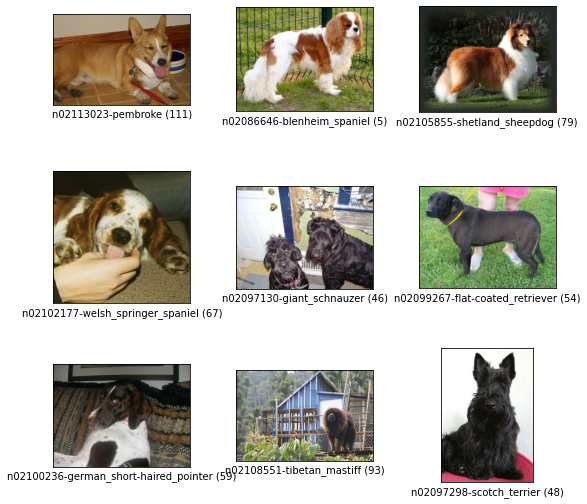

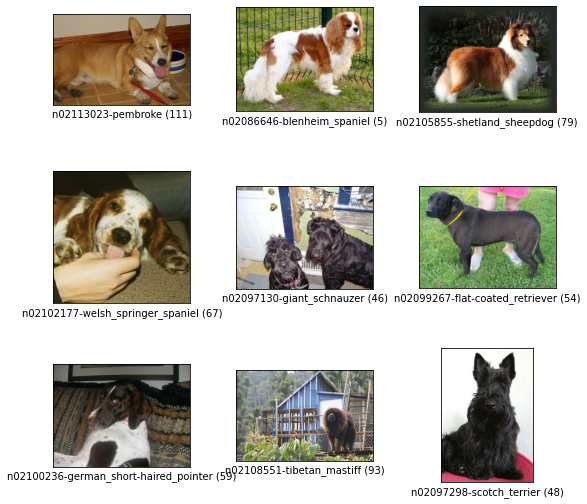

In [4]:
tfds.show_examples(ds_train,ds_info)

### 텐서플로우 Random Augmentation API 사용
>random_brightness()  
random_contrast()  
random_crop()  
random_flip_left_right()  
random_flip_up_down()  
random_hue()  
random_jpeg_quality()  
random_saturation()  

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


In [6]:
#random_flip_left_right
#random_brightness
def augment(image,label):
    image = tf.image.random_flip_left_right(image)            
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [8]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [9]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

NameError: name 'aug_resnet50' is not defined

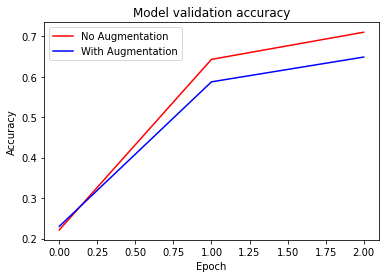

In [13]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

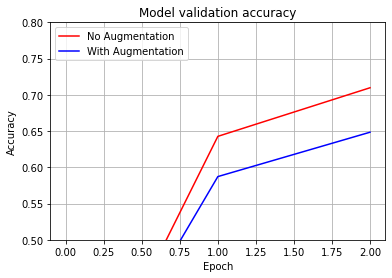

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### Cutmix

1. 이미지 섞기

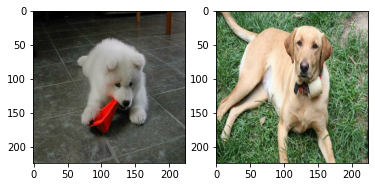

In [46]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

* bounding box의 위치 찾기

In [22]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(2, shape=(), dtype=int32) tf.Tensor(140, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(117, shape=(), dtype=int32)


* bounding box 바깥: image_a
* bounding box 안: image_b

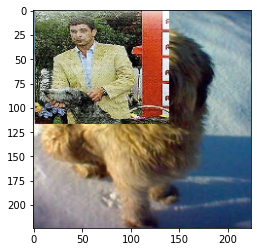

In [23]:
# mix two images
# 왼쪽,위에서 부터 시작
# x:y 반전
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

2. 라벨 섞기  
* CutMix에서는 면적에 비례해서 라벨을 섞어줍니다.

In [24]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.3217873, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.6782127, 0.       , 0.       ,
   

* batch단위의 cutmix() 생성
* 위의 3개 함수(get_clip_box,mix_2_images,mix_2_labels)

In [25]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### Mixup

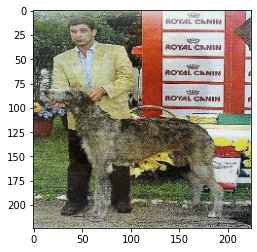

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.8437779 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.1562221 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [26]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

* batch단위의 mixup() 생성

In [27]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# Project

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 1. Augmentation을 적용한 데이터셋 만들기

* 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다.
* 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [2]:
# get_clip_box 함수 정의 그대로 사용
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)
    
    return x_min, y_min, x_max, y_max

# mix_2_images 함수 정의 그대로 사용
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

# mix_2_labels 함수에서 image_a와 image_b 인자 추가
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# cutmix 함수에서 num_classes를 인자로 받아 사용
def cutmix(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [3]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:  # 변경된 부분
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )   
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug= apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True) # 변경된 부분
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True) # 변경된 부분
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### 2. 모델 만들기
* 앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [6]:
# num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 0s 0us/step
=3


In [7]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


### 3. 모델 훈련하기
* sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [35]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 5

resnet50.compile(
    loss='categorical_crossentropy', # 'categorical_crossentropy'로 변경
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 164s 209ms/step - loss: 0.0240 - accuracy: 0.9992 - val_loss: 0.9266 - val_accuracy: 0.7416
Epoch 2/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0164 - accuracy: 0.9992 - val_loss: 0.9347 - val_accuracy: 0.7435
Epoch 3/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0132 - accuracy: 0.9995 - val_loss: 0.9466 - val_accuracy: 0.7445
Epoch 4/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0099 - accuracy: 0.9996 - val_loss: 0.9561 - val_accuracy: 0.7430
Epoch 5/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0076 - accuracy: 0.9999 - val_loss: 0.9628 - val_accuracy: 0.7436


In [9]:
aug_resnet50.compile(
    loss='categorical_crossentropy', # 'categorical_crossentropy'로 변경
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [37]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 159s 208ms/step - loss: 0.1165 - accuracy: 0.9826 - val_loss: 0.8713 - val_accuracy: 0.7490
Epoch 2/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0516 - accuracy: 0.9938 - val_loss: 0.8577 - val_accuracy: 0.7592
Epoch 3/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0314 - accuracy: 0.9971 - val_loss: 0.8585 - val_accuracy: 0.7601
Epoch 4/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0272 - accuracy: 0.9975 - val_loss: 0.8645 - val_accuracy: 0.7583
Epoch 5/5
750/750 [==============================] - 156s 208ms/step - loss: 0.0162 - accuracy: 0.9990 - val_loss: 0.8576 - val_accuracy: 0.7638


In [38]:
history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_aug_cutmix, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 163s 211ms/step - loss: 2.0611 - accuracy: 0.7299 - val_loss: 1.1295 - val_accuracy: 0.6978
Epoch 2/5
750/750 [==============================] - 157s 210ms/step - loss: 1.9975 - accuracy: 0.7389 - val_loss: 1.2893 - val_accuracy: 0.6688
Epoch 3/5
750/750 [==============================] - 158s 210ms/step - loss: 1.9368 - accuracy: 0.7499 - val_loss: 1.3172 - val_accuracy: 0.6637
Epoch 4/5
750/750 [==============================] - 161s 214ms/step - loss: 1.9020 - accuracy: 0.7594 - val_loss: 1.1991 - val_accuracy: 0.6964
Epoch 5/5
750/750 [==============================] - 159s 213ms/step - loss: 1.9073 - accuracy: 0.7580 - val_loss: 1.1429 - val_accuracy: 0.7091


In [39]:
history_resnet50_aug_mixup = aug_resnet50.fit(
    ds_train_aug_mixup, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 165s 210ms/step - loss: 1.9675 - accuracy: 0.8076 - val_loss: 1.3973 - val_accuracy: 0.6522
Epoch 2/5
750/750 [==============================] - 157s 210ms/step - loss: 1.9128 - accuracy: 0.8224 - val_loss: 1.4203 - val_accuracy: 0.6476
Epoch 3/5
750/750 [==============================] - 158s 210ms/step - loss: 1.8939 - accuracy: 0.8249 - val_loss: 1.3754 - val_accuracy: 0.6588
Epoch 4/5
750/750 [==============================] - 157s 210ms/step - loss: 1.8718 - accuracy: 0.8298 - val_loss: 1.2437 - val_accuracy: 0.6906
Epoch 5/5
750/750 [==============================] - 158s 211ms/step - loss: 1.8572 - accuracy: 0.8373 - val_loss: 1.2166 - val_accuracy: 0.6976


### 4. 훈련 과정 시각화하기

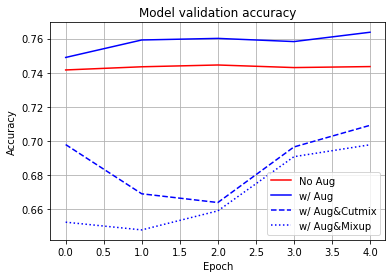

In [41]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b--')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b:')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'w/ Aug','w/ Aug&Cutmix','w/ Aug&Mixup'], loc='lower right')
plt.grid(True)
# plt.ylim(0., 0.75) 
plt.show()

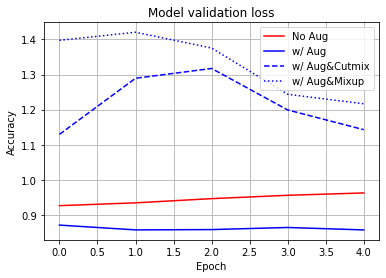

In [43]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'b--')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'b:')
plt.title('Model validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'w/ Aug','w/ Aug&Cutmix','w/ Aug&Mixup'], loc='upper right')
plt.grid(True)
# plt.ylim(0.8, 2.) 
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
* No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교
* Augmentation 방법들의 영향도에 대해 분석해 보세요.

> epoch수가 충분하지 않아 확실한 정확도 성능 비교는 어려운 상태입니다.하지만 '기본+Cutmix'의 초반 학습속도가 느린 것은 확인할 수 있었습니다.

> Augmentation의 일반적 특징은 아래와 같으며, **실험결과와 관련된 특이사항을 추가하였습니다.**

1. 원본 데이터 (No Augmentation)
    - 장점: 데이터가 그대로 사용되므로, 모델이 데이터의 자연스러운 특성을 배울 수 있습니다.
    - 단점: 데이터가 충분하지 않을 경우 과적합(overfitting)이 발생할 가능성이 높습니다. 모델의 일반화 성능이 낮을 수 있습니다.
2. 기본 증강 (좌우 반전, 밝기 조정)
    - 장점: 간단한 증강 기법을 통해 데이터의 다양성을 높이고, 모델이 데이터의 다양한 변형에 잘 대응할 수 있게 합니다. 과적합을 방지하고 -일반화 성능을 향상시킬 수 있습니다.
    - 단점: 증강 기법이 제한적이므로 데이터 다양성의 증가가 한정적일 수 있습니다.
3. 기본 증강 + CutMix
CutMix: 두 개의 이미지를 섞는 대신, 한 이미지의 일부를 잘라내어 다른 이미지에 붙이는 기법입니다.
    - 장점: 모델이 객체의 일부분을 인식하는 데 강해집니다. 또한, CutMix는 학습 데이터를 더욱 다양하게 만들어 일반화 성능을 크게 향상시킬 수 있습니다.
    - 단점: 이미지가 불규칙하게 변형되므로 학습 초기에는 모델이 적응하는 데 시간이 걸릴 수 있습니다.
> 실제로 학습과정의 속도가 느린 걸 확인할 수 있었다.    
4. 기본 증강 + MixUp
MixUp: 두 개의 이미지를 선형으로 혼합하는 기법입니다.
    - 장점: 모델이 두 이미지의 혼합된 정보를 학습하도록 유도하여, 모델이 데이터의 연속적인 변화를 더 잘 이해할 수 있게 합니다. 이로 인해 과적합이 줄어들고 일반화 성능이 향상됩니다.
    - 단점: 이미지가 자연스럽지 않을 수 있으며, 원본 이미지의 의미가 왜곡될 수 있습니다.

# 회고
* resne50모델의 층이 깊어서 그런지, 모델 작동시간이 체감될 정도로 오래 걸렸다.
* 작동시간이 오래 걸려서 epoch횟수 증대에 제한사항이 되었다.
* Cutmix와 Mixup이 초반에 서로 다른 양상을 보인 것은 예상 밖이었다.